Context: This script uses Raymotime data (https://www.lasse.ufpa.br/raymobtime/) in the context of the UFPA - ITU Artificial Intelligence/Machine Learning in 5G Challenge (http://ai5gchallenge.ufpa.br/).

Authors: Ailton Oliveira, Aldebaro Klautau, Arthur Nascimento, Diego Gomes, Jamelly Ferreira, Walter Frazao

In [3]:
'''
Train a deep NN for choosing top-K beams.
Note that you need to download the datasets and save them in the folder specified in this code. 
'''

#Import modules
import os
import csv
import argparse
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.models import model_from_json,Model
from tensorflow.keras.layers import Dense,concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta,Adam
from sklearn.model_selection import train_test_split
from ml4comm.model_handler import ModelHandler

In [1]:
#Make sure the datasets below can be found in the specific folders.
#If running on Colab, you may use /content/
COORDINATES_INPUT_FILE = "./data/coord_input/coord_input.npz"
IMAGES_INPUT_FILE = "./data/image_input/img_input.npz"
LIDAR_INPUT_FILE = "./data/lidar_input/lidar_input.npz"
BEAM_OUTPUT_FILE = "./data/beam_output/beams_output.npz"

In [10]:
###############################################################################
# Support functions
###############################################################################

#For description about top-k, including the explanation on how they treat ties (which can be misleading
#if your classifier is outputting a lot of ties (e.g. all 0's will lead to high top-k)
#https://www.tensorflow.org/api_docs/python/tf/nn/in_top_k
#define top-k accuracy for different values of k
def top_10_accuracy(y_true,y_pred):
    return metrics.top_k_categorical_accuracy(y_true,y_pred,k=10)

def top_30_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=30)

def top_50_accuracy(y_true,y_pred):
    return metrics.top_k_categorical_accuracy(y_true,y_pred,k=50)

def top_100_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=100)

#convert pair of indices to a single index
def sub2ind(array_shape, rows, cols):
    ind = rows*array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    return ind

#convert index into a pair of indices
def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = (ind.astype('int') / array_shape[1])
    cols = ind % array_shape[1]
    return (rows, cols)

#converts to log scale and make zero the values below the specified threshold
def beamsLogScale(y,thresholdBelowMax):
        y_shape = y.shape
        
        for i in range(0,y_shape[0]):            
            thisOutputs = y[i,:]
            logOut = 20*np.log10(thisOutputs + 1e-30)
            minValue = np.amax(logOut) - thresholdBelowMax
            zeroedValueIndices = logOut < minValue
            thisOutputs[zeroedValueIndices]=0
            thisOutputs = thisOutputs / sum(thisOutputs)
            y[i,:] = thisOutputs
        
        return y

def getBeamOutput(output_file):
    
    thresholdBelowMax = 60
    
    print("Reading dataset...", output_file)
    output_cache_file = np.load(output_file)
    yMatrix = output_cache_file['output_classification']
    
    yMatrix = np.abs(yMatrix)
    yMatrix /= np.max(yMatrix)
    yMatrixShape = yMatrix.shape
    num_classes = yMatrix.shape[1] * yMatrix.shape[2]
    
    y = yMatrix.reshape(yMatrix.shape[0],num_classes)
    y = beamsLogScale(y,thresholdBelowMax)
    
    return y,num_classes

In [12]:
###############################################################################
# Data configuration
###############################################################################

tf.device('/device:GPU:0')

#Here you can choose a combination of sets of parameters to be used as the neural network input
coord = False  #coordinates with the receiver position obtained from GPS
img = False  #RGB images obtained from cameras
lidar = True  #three-dimensional histogram obtained form LIDAR point cloud

num_epochs = 2 #assume a rather small number just to demo things. You should try larger values
batch_size = 32
tgtRec = 3
seed = 7

np.random.seed(seed)

if coord == True: 
    #train
    coord_train_cache_file = np.load(COORDINATES_INPUT_FILE)
    X_coord = coord_train_cache_file['coordinates']
    X_coord_train, X_coord_validation = train_test_split(X_coord, test_size=0.2, random_state=seed, shuffle=True)
    print("Reading dataset... ",COORDINATES_INPUT_FILE)
    coord_train_input_shape = X_coord_train.shape

if img == True:
    resizeFac = 20 # Resize Factor
    nCh = 1 # The number of channels of the image
    imgDim = (360,640) # Image dimensions
    method = 1

    #train
    img_train_cache_file = np.load(IMAGES_INPUT_FILE)
    X_img = img_train_cache_file['inputs']
    X_img_train, X_img_validation = train_test_split(X_img, test_size=0.2, random_state=seed, shuffle=True)
    print("Reading dataset... ",IMAGES_INPUT_FILE)

    img_train_input_shape = X_img_train.shape

if lidar == True:
    #train
    lidar_train_cache_file = np.load(LIDAR_INPUT_FILE)
    X_lidar = lidar_train_cache_file['input']
    X_lidar_train, X_lidar_validation = train_test_split(X_lidar, test_size=0.2, random_state=seed, shuffle=True)
    print("Reading dataset... ",LIDAR_INPUT_FILE)
    lidar_train_input_shape = X_lidar_train.shape

###############################################################################
# Output configuration
#train
y_output,num_classes = getBeamOutput(BEAM_OUTPUT_FILE)
y_train, y_validation = train_test_split(y_output, test_size=0.2, random_state=seed, shuffle=True)

Reading dataset...  ./data/lidar_input/lidar_input.npz
Reading dataset... ./data/beam_output/beams_output.npz


In [13]:
print(y_output[1,:])

[0.00146982 0.00056125 0.00055414 0.00044021 0.00045633 0.00039816
 0.00036833 0.00034294 0.00032207 0.0003045  0.00028888 0.00027398
 0.00027869 0.00080263 0.00034824 0.00029878 0.00024877 0.00027781
 0.00135507 0.00034706 0.00071369 0.         0.00068005 0.00070506
 0.00083613 0.0010586  0.00176501 0.00251836 0.00917728 0.00549423
 0.00242845 0.0013558  0.0016544  0.00062371 0.0006203  0.00049732
 0.00051177 0.00044754 0.00041425 0.00038595 0.00036278 0.00034369
 0.00032861 0.00032506 0.00045562 0.00168838 0.00055609 0.00046739
 0.00048498 0.00134429 0.00214406 0.00049101 0.0007783  0.
 0.0007139  0.00076337 0.00091534 0.00116641 0.00197566 0.00279639
 0.01021861 0.00613227 0.00270514 0.00152045 0.00262671 0.00117486
 0.00117904 0.00100761 0.00104231 0.00096609 0.0009359  0.00091886
 0.0009174  0.0009344  0.00097888 0.00108477 0.00151075 0.00302151
 0.00117956 0.00130951 0.00175391 0.00045254 0.00262179 0.02541165
 0.00187437 0.00137173 0.         0.00028012 0.00060813 0.00103675
 0.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 200, 10)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 200, 10)       16910     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 200, 10)       12110     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 40, 10)         0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 40, 10)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 40, 10)         4910      
_________

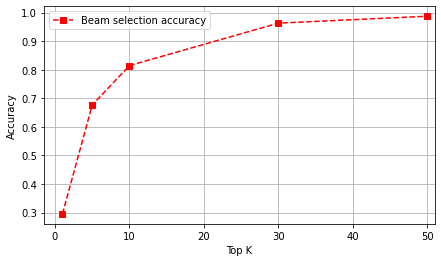

In [7]:
##############################################################################
# Model configuration
##############################################################################

#multimodal
multimodal = [coord, img, lidar]
plot = True # Active Plot output

#validationFraction = 0.2 #from 0 to 1
modelHand = ModelHandler()
opt = Adam()

if coord:
    coord_model = modelHand.createArchitecture('coord_mlp',num_classes,coord_train_input_shape[1],'complete')
if img:
    if nCh==1:   
        img_model = modelHand.createArchitecture('light_image',num_classes,[img_train_input_shape[1],img_train_input_shape[2],1],'complete')
    else:
        img_model = modelHand.createArchitecture('light_image',num_classes,[img_train_input_shape[1],img_train_input_shape[2],img_train_input_shape[3]],'complete')
if lidar:
    lidar_model = modelHand.createArchitecture('lidar_simple',num_classes,[lidar_train_input_shape[1],lidar_train_input_shape[2],lidar_train_input_shape[3]],'complete')

if sum(multimodal) == 2:
    if coord and lidar:
        combined_model = concatenate([coord_model.output,lidar_model.output])
        z = Dense(num_classes,activation="relu")(combined_model)
        model = Model(inputs=[coord_model.input,lidar_model.input],outputs=z)
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit([X_coord_train,X_lidar_train],y_train, 
        validation_data=([X_coord_validation, X_lidar_validation], y_validation),epochs=num_epochs,batch_size=batch_size)

    elif coord and img:
        combined_model = concatenate([coord_model.output,img_model.output])
        z = Dense(num_classes,activation="relu")(combined_model)
        model = Model(inputs=[coord_model.input,img_model.input],outputs=z)
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit([X_coord_train,X_img_train],y_train,
        validation_data=([X_coord_validation, X_img_validation], y_validation), epochs=num_epochs,batch_size=batch_size)
    
    else:
        combined_model = concatenate([lidar_model.output,img_model.output])
        z = Dense(num_classes,activation="relu")(combined_model)
        model = Model(inputs=[lidar_model.input,img_model.input],outputs=z)
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit([X_lidar_train,X_img_train],y_train, 
        validation_data=([X_lidar_validation, X_img_validation], y_validation), epochs=num_epochs,batch_size=batch_size)

elif sum(multimodal) == 3:
    combined_model = concatenate([lidar_model.output,img_model.output, coord_model.output])
    z = Dense(num_classes,activation="relu")(combined_model)
    model = Model(inputs=[lidar_model.input,img_model.input, coord_model.input],outputs=z)
    model.compile(loss=categorical_crossentropy,
                optimizer=opt,
                metrics=[metrics.categorical_accuracy,
                        metrics.top_k_categorical_accuracy,
                        top_10_accuracy,
                        top_30_accuracy,
                        top_50_accuracy,
                        top_100_accuracy])
    model.summary()
    hist = model.fit([X_lidar_train,X_img_train,X_coord_train],y_train,
            validation_data=([X_lidar_validation, X_img_validation, X_coord_validation], y_validation),
            epochs=num_epochs,batch_size=batch_size)

else:
    if coord:
        model = coord_model
        model.compile(loss=categorical_crossentropy,
                            optimizer=opt,
                            metrics=[metrics.categorical_accuracy,
                                    metrics.top_k_categorical_accuracy,
                                    top_10_accuracy,
                                    top_30_accuracy, 
                                    top_50_accuracy,
                                    top_100_accuracy])
        model.summary()
        hist = model.fit(X_coord_train,y_train, 
        validation_data=(X_coord_validation, y_validation),epochs=num_epochs,batch_size=batch_size)

    elif img:
        model = img_model  
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit(X_img_train,y_train, 
        validation_data=(X_img_validation, y_validation),epochs=num_epochs,batch_size=batch_size)

    else:
        model = lidar_model
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit(X_lidar_train,y_train,epochs=num_epochs,batch_size=batch_size, validation_data=(X_lidar_validation, y_validation))

with open('history.txt', 'w') as f: 
       f.write(str(hist.history))

if plot:
       k_beams = [1, 5, 10, 30, 50]
       fig, ax = plt.subplots(figsize=(7,4))
       # acurracy's
       y = [max(hist.history['categorical_accuracy']),
       max(hist.history['top_k_categorical_accuracy']),
       max(hist.history['top_10_accuracy']),
       max(hist.history['top_30_accuracy']),
       max(hist.history['top_50_accuracy'])]
       ax.plot(k_beams,y, 'r--s', label = 'Beam selection accuracy')
       # original labels
       '''ax.plot(k_beams,y_ori, 'b--s', label = 'Correct orientation-LIDAR')
       ax.plot(k_beams,y_sori, 'k--s', label = 'Fixed oientation-LIDAR ')
       ax.plot(k_beams,y_MM_ori, 'm--s', label = 'Correct orientation-MM')
       ax.plot(k_beams,y_MM_sori, 'r--s', label = 'Fixed oientation-MM')'''
       ax.set(xlabel='Top K', ylabel='Accuracy')
       plt.xlim(right=51)
       ax.grid()
       plt.legend()
       plt.show()

## **Accuracy / epochs**

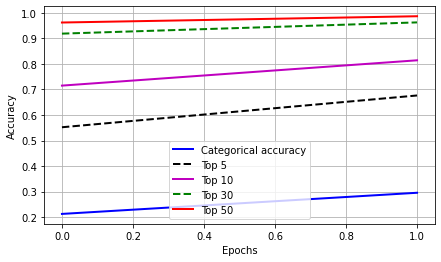

In [14]:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(hist.history['categorical_accuracy'], 'b', label = 'Categorical accuracy', linewidth=2)
ax.plot(hist.history['top_k_categorical_accuracy'], 'k--', label = 'Top 5', linewidth=2)
ax.plot(hist.history['top_10_accuracy'], 'm', label = 'Top 10', linewidth=2)
ax.plot(hist.history['top_30_accuracy'], 'g--', label = 'Top 30', linewidth=2)
ax.plot(hist.history['top_50_accuracy'], 'r', label = 'Top 50', linewidth=2)
ax.set(xlabel='Epochs', ylabel='Accuracy')
ax.grid()
plt.legend()
plt.show()

## **Accuracy / Top k**

In [15]:
def top_n_Rt(y_predict,valid_, N = 1):
    predict = y_predict[:,:N]
    original= valid_[:,-N:]
    rt = np.sum(1+predict) / np.sum(1+original)
    return rt

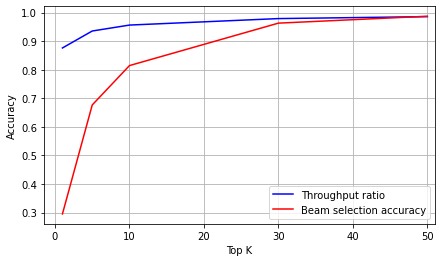

In [16]:
y_predict = model.predict(X_lidar_validation)
valid_ = np.sort(y_validation)

y = [max(hist.history['categorical_accuracy']),
     max(hist.history['top_k_categorical_accuracy']),
     max(hist.history['top_10_accuracy']),
     max(hist.history['top_30_accuracy']),
     max(hist.history['top_50_accuracy'])]
y_rt=[]
k_beams = [1, 5, 10, 30, 50]
for i in k_beams:
    rt = top_n_Rt(y_predict,valid_,i)
    y_rt.append(rt)
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(k_beams,y_rt, 'b', label = 'Throughput ratio')
ax.plot(k_beams,y, 'r', label = 'Beam selection accuracy')
ax.set(xlabel='Top K', ylabel='Accuracy')
plt.xlim(right=51)
ax.grid()
plt.legend()
plt.show()

## **Throughput ratio**

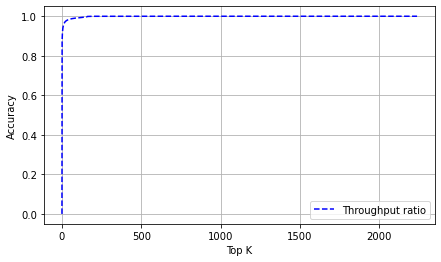

In [17]:
y_predict = model.predict(X_lidar_validation)
valid_ = np.sort(y_validation)
examples = valid_.shape[0]
y=[]
for i in range(examples):
    rt = top_n_Rt(y_predict,valid_,i)
    y.append(rt)
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(y[:], 'b--', label = 'Throughput ratio')
ax.set(xlabel='Top K', ylabel='Accuracy')
ax.grid()
plt.legend()
plt.show()

## **Save output**

In [18]:
fileNameIdentifier = 'training_history'
f = open(fileNameIdentifier + '.txt','w')
f.write(str(hist.history))
f.close()